# "Прогнозирование температуры плавления стали"

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

# Анализ исходных данных

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from pyod.models.knn import KNN
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

## Данные об электродах

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_arc.info()
data_arc.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [3]:
data_arc[data_arc['Реактивная мощность'] < 0]['Реактивная мощность']

9780   -715.504924
Name: Реактивная мощность, dtype: float64

In [4]:
len(data_arc['key'].unique())

3214

In [5]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [6]:
data_arc.tail(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14866,3240,2019-09-01 02:35:24,2019-09-01 02:37:25,0.411601,0.274390
14867,3240,2019-09-01 02:40:55,2019-09-01 02:43:28,0.521811,0.378517
14868,3240,2019-09-01 03:08:38,2019-09-01 03:11:08,0.518065,0.528780
14869,3240,2019-09-01 03:12:34,2019-09-01 03:17:08,0.983723,0.884585
14870,3240,2019-09-01 03:31:47,2019-09-01 03:34:08,0.548882,0.416994
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708


Text(0, 0.5, 'Количество')

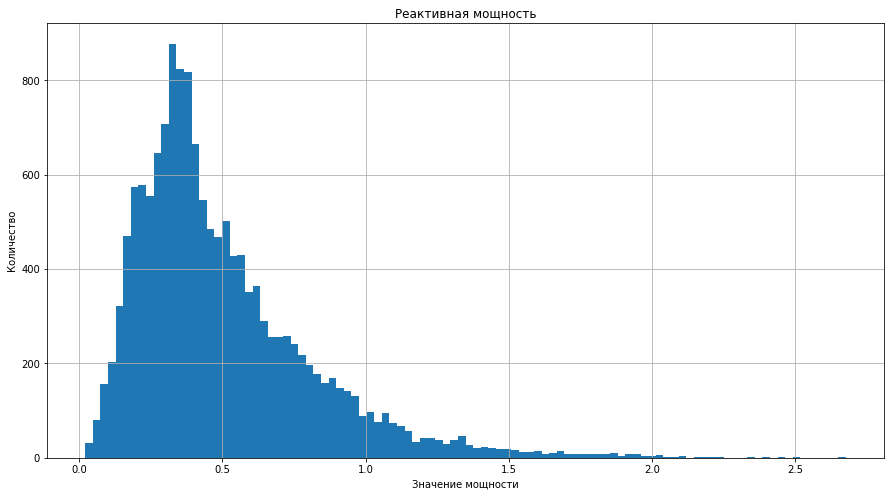

In [7]:
data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist(bins=100, figsize=(15,8))
plt.title("Реактивная мощность")
plt.xlabel("Значение мощности")
plt.ylabel("Количество")

Text(0, 0.5, 'Количество')

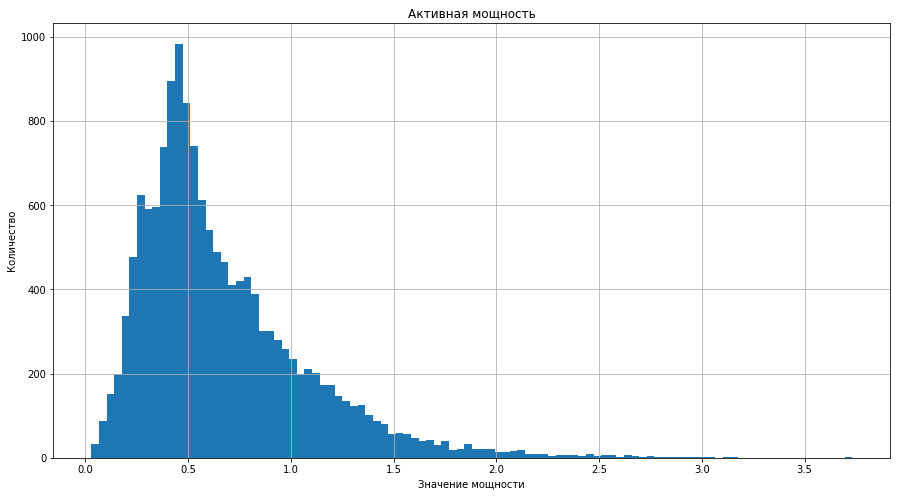

In [8]:
data_arc['Активная мощность'].hist(bins=100, figsize=(15,8))
plt.title("Активная мощность")
plt.xlabel("Значение мощности")
plt.ylabel("Количество")

В данных присутствует аномалия по реактивной мощности. Время в формате object, нужно перевести в datetime. Данные мощностей(реакт. и актив.) смещенны влево.

## Данные о подаче сыпучих материалов (объём)

In [9]:
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk.info()
data_bulk.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [10]:
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [11]:
len(data_bulk['key'].unique())

3129

Text(0.5, 1.0, 'Диаграмма размаха для всех сыпучих материалов')

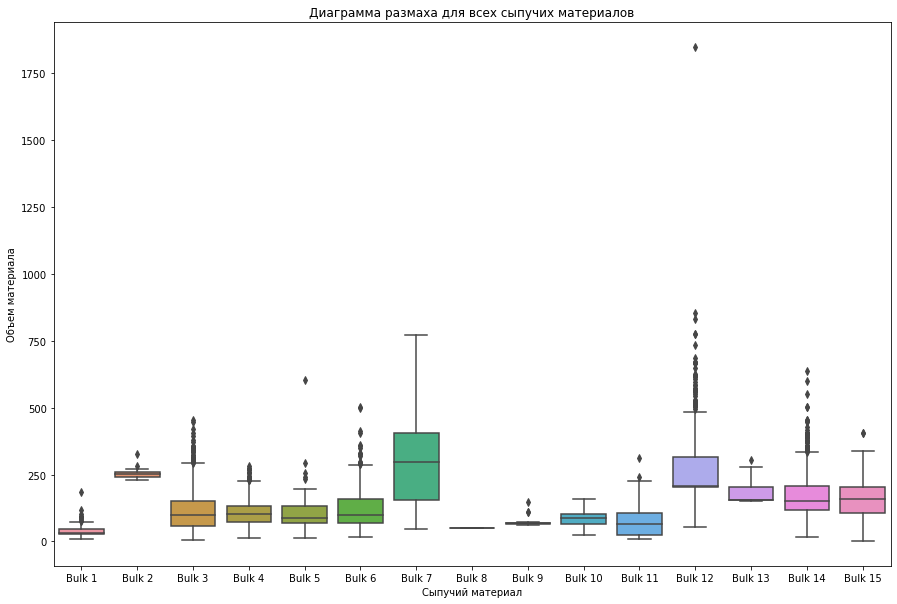

In [12]:
fig = plt.figure(figsize=(15,10))
sns.boxplot(data=data_bulk.drop('key', axis=1))
plt.xlabel("Сыпучий материал")
plt.ylabel("Объем материала")
plt.title("Диаграмма размаха для всех сыпучих материалов")

Из диаграммы размаха видим, что существенные выбросы имеются только для присадок 5 и 12. Возможно, что данные партии потребовали большее количество сыпучих материлов по сравнению со всеми остальными, удалять такие данные нецелесообразно.

Столбец key нужно перевести в int.
Присутствуют большие пропуски данных, возможно это связано с добавлением разного количества сыпучих материалов в смеси, в том числе и не добавлением их, а может это ошибки датчика, но данные восстановить корректно не получится.
Данные перевести из float в int. Есть пропуски по ключам, вероятно данные утеряны.

## Данные о подаче сыпучих материалов (время)


In [13]:
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_bulk_time.info()
data_bulk_time.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [14]:
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


In [15]:
len(data_bulk_time['key'].unique())

3129

Отсутствуют данные по времени, похоже на отсутствие данные подачи сыпучих материалов. Нужно сравнить NaNы.

## Данные о продувке сплава газом

In [16]:
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_gas.info()
data_gas.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [17]:
data_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [18]:
len(data_gas['key'].unique())

3239

Text(0.5, 1.0, 'Газ 1')

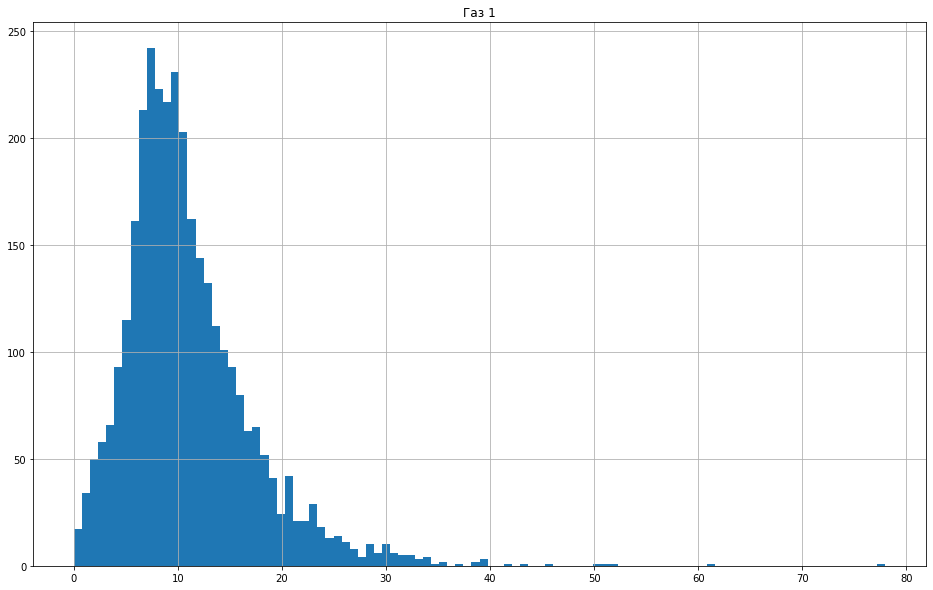

In [19]:
data_gas['Газ 1'].hist(bins=100, figsize=(16,10))
plt.title('Газ 1')

Газ добавляется в каждую партию.
Объем газа имеет нормальное распределение скошенное немного вправо.
Пропуски в данных по газу отсутствуют

## Результаты измерения температуры

In [20]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_temp.info()
data_temp.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [21]:
data_temp.head(15)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [22]:
data_temp.tail(15)

,key,Время замера,Температура
15892,3239,2019-09-01 02:23:02,NaN
15893,3239,2019-09-01 02:24:15,NaN
15894,3240,2019-09-01 02:39:01,1617.0
15895,3240,2019-09-01 02:48:33,NaN
15896,3240,2019-09-01 03:03:21,NaN
15897,3240,2019-09-01 03:12:19,NaN
15898,3240,2019-09-01 03:19:09,NaN
15899,3240,2019-09-01 03:31:27,NaN
15900,3240,2019-09-01 03:34:31,NaN
15901,3240,2019-09-01 03:35:16,NaN


In [23]:
len(data_temp['key'].unique())

3216

Text(0.5, 1.0, 'Распределение замеров температуры')

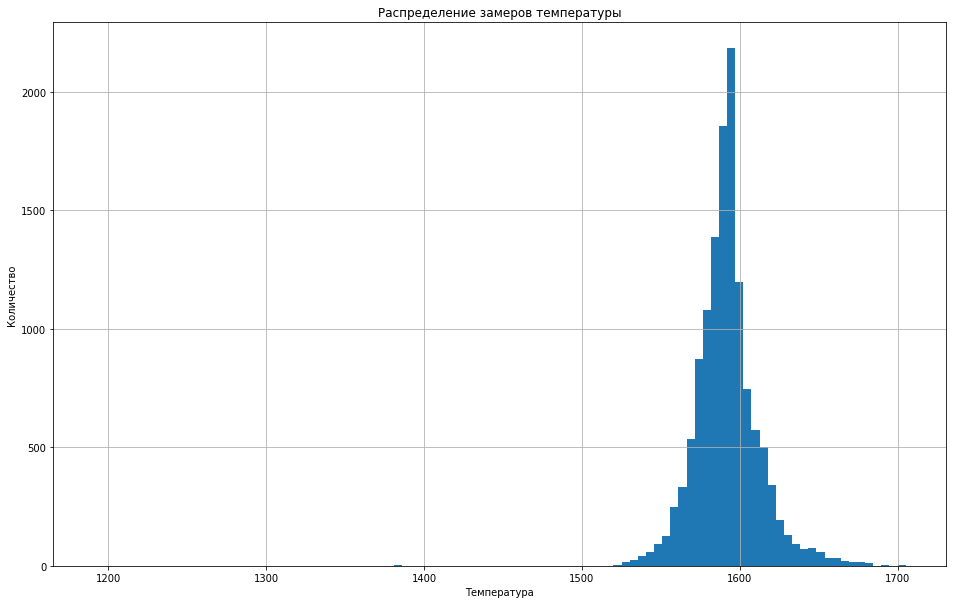

In [24]:
data_temp['Температура'].hist(bins=100, figsize=(16,10))
plt.xlabel('Температура')
plt.ylabel("Количество")
plt.title("Распределение замеров температуры")

Присутствуют пропуски ключевого признака - последней температуры, наверное приведет к удалению всех данных по ключу.

## Данные о проволочных материалах (объём)

In [25]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire.info()
data_wire.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [26]:
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
len(data_wire['key'].unique())

3081

Text(0.5, 1.0, 'Диаграмма размаха для всех проволочных материалов')

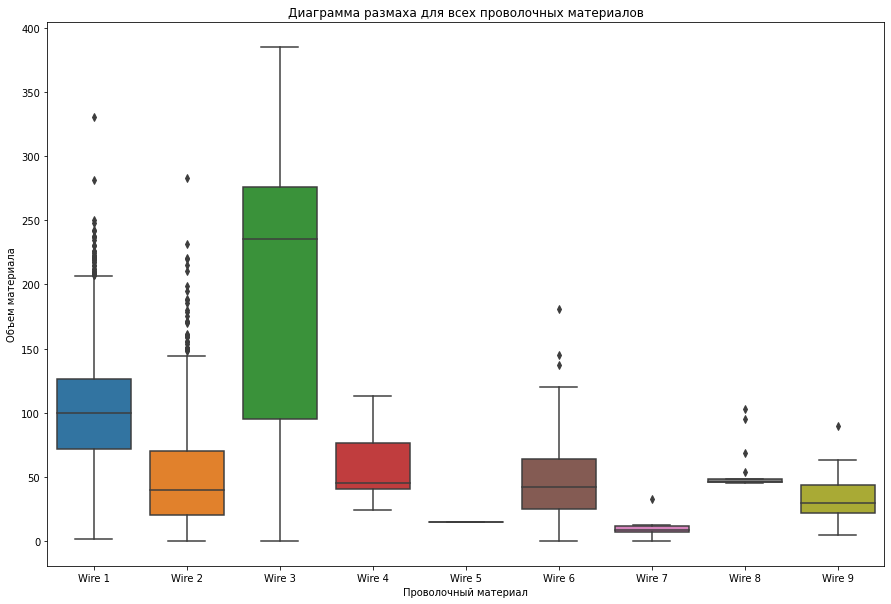

In [28]:
fig = plt.figure(figsize=(15,10))
sns.boxplot(data=data_wire.drop('key', axis=1))
plt.xlabel("Проволочный материал")
plt.ylabel("Объем материала")
plt.title("Диаграмма размаха для всех проволочных материалов")

Объем материалов разнится в зависимости от партии.
Значительные выбросы замечены только для проволочного материала № 8. Он добавлялся всего в 19 партий, поэтому можно предположить, что выбросы обусловлены небольшим количеством данных по данному материалу.

## Данные о проволочных материалах (время)

In [29]:
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
data_wire_time.info()
data_wire_time.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [30]:
data_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
len(data_wire_time['key'].unique())

3081

Данные по времени добавления проволочных материалов одинаковы по структуре с данными объемами материалов.

# Вывод

Присутствуют большие пропуски данных, возможно это связано с добавлением разного количества сыпучих материалов в смеси, в том числе и не добавлением их, а может это ошибки датчика, но данные восстановить корректно не получится.
Во многих таблицах отсутствуют данные уникальных номеров партии 'key'.
Есть неправильное использование типа числа с плавающей точкой, времени в формате object вместо datetime.
Используется русскоязычные названия столбцов и  использование пробелов в названиях, что может приводить к ошибкам при обращении, нужно переименовать.
Количество записей в одной партии для каждой таблицы может различаться.
Аномальное значение реактивной мощности в таблице data_arc.
Данные требуют предобработки и группировки по признаку key.
В некоторых партиях время последнего замера температуры происходило до конца нагрева.

# Перечень планируемых работ

1) Проведем предобработку данных.
Целевой признак - конечная температура.

2) Создадим таблицу, где просуммируем активную и реактивную мощность для каждой партии. Это снизит вычислительную нагрузку.

3) Создадим таблицу, где есть первый и последний замер температуры.

4) Для таблиц data_bulk и data_wire заполним пропуски нулями (предполагаем, что пропуски не являются ошибкой, а означают отсутствие подачи)

5) Приведем типы данных к целочисленным для ускорения работы и для правильной отработки алгоритмов.

6) В каждой таблице преобразуем index в значение столбца key.

7) Выполним оценку мультиколлинеарности

8) Разобьем данные на train/test в соотношении 80/20.

9) Проведём обучение модели с поиском оптимальных параметров с помощью GridSearchCV. Для обучения воспользуемся следующими алгоритмами: LinearRegression, RandomForest, LightGBM, Сatboost.

10) Тестируем ТОЛЬКО лучшую модель.

# Подготовка данных

In [32]:
# Переименуем столбцы и уберем пробелы
data_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']
data_gas.columns = ['key', 'gas']
data_temp.columns = ['key', 'measurement_time', 'temperature']
data_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
data_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']


In [33]:
# Избавимся от ошибоке в данных
data_arc = data_arc.query('reactive_power > 0') 

In [34]:
# Создаем таблицу, где сложим активную и реактивную мощность для каждой партии
data_arc_sum = pd.pivot_table(data_arc,
                             values=['active_power','reactive_power'],
                             index='key',
                             aggfunc={'active_power': np.sum,
                                      'reactive_power': np.sum})
data_arc_sum.columns = ['sum_active_power','sum_reactive_power']
data_arc_sum

,sum_active_power,sum_reactive_power
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643
...,...,...
3237,3.932467,2.828459
3238,2.106529,1.681182
3239,4.666754,3.111617


In [35]:
# Создаем таблицу, где есть первый и последний замер температуры
keys = []
for key in list(data_temp['key'].unique()):
    try:
        if (data_temp[data_temp['key'] == key]['measurement_time'].max() < 
            data_arc[data_arc['key'] == key]['end_time'].max()): 
            keys.append(key)
    except:
        keys.append(key)
data_temp = data_temp.query('key not in @keys')

In [36]:
# избавимся от пропусков замеров
data_temp = data_temp.dropna() 

In [37]:
# удаляем партии с одним замером температуры
for i in (data_temp['key'].unique()): 
    if (data_temp['key']==i).sum() < 2:
        data_temp = data_temp[data_temp.key != i]

In [38]:
data_temp_time = data_temp.pivot_table(index=['key'], values=('temperature', 'measurement_time'), aggfunc=['first', 'last'])

In [39]:
data_temp_time.columns = ['first_time', 'first_temperature', 'last_time', 'last_temperature']
display(data_temp_time)

,first_time,first_temperature,last_time,last_temperature
key,,,,
1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
...,...,...,...,...
2495,2019-08-06 00:35:45,1570.0,2019-08-06 00:54:42,1591.0
2496,2019-08-06 01:02:54,1554.0,2019-08-06 01:29:52,1591.0
2497,2019-08-06 01:41:53,1571.0,2019-08-06 01:53:50,1589.0


In [40]:
# Присваеваем индексам номер партии
data_bulk = data_bulk.set_index('key').fillna(0) # добавлен fillna(0)
data_gas = data_gas.set_index('key').fillna(0)   # добавлен fillna(0)
data_wire = data_wire.set_index('key').fillna(0) # добавлен fillna(0)

In [41]:
# Собираем все по индексу
data = pd.concat([data_temp_time, data_arc_sum, data_bulk, data_gas, data_wire], axis=1, sort=False)
display(data)

,first_time,first_temperature,last_time,last_temperature,sum_active_power,sum_reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,...,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,4.878147,3.183241,0.0,0.0,0.0,43.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,3.052598,1.998112,0.0,0.0,0.0,73.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,2.525882,1.599076,0.0,0.0,0.0,34.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,3.209250,2.060298,0.0,0.0,0.0,81.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,3.347173,2.252643,0.0,0.0,0.0,78.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,NaN,NaN,NaN,NaN,3.932467,2.828459,0.0,0.0,170.0,0.0,...,5.543905,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3238,NaN,NaN,NaN,NaN,2.106529,1.681182,0.0,0.0,126.0,0.0,...,6.745669,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3239,NaN,NaN,NaN,NaN,4.666754,3.111617,0.0,0.0,0.0,0.0,...,16.023518,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Время замера не информативно,т.к. за это время происходило разное колличество дествий
data = data.drop('first_time',axis=1)
data = data.drop('last_time',axis=1)
data = data.dropna(subset=['last_temperature'])
#data = data.fillna(0)


In [43]:
display(data)

,first_temperature,last_temperature,sum_active_power,sum_reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,4.878147,3.183241,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1581.0,1602.0,3.052598,1.998112,0.0,0.0,0.0,73.0,0.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1596.0,1599.0,2.525882,1.599076,0.0,0.0,0.0,34.0,0.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1601.0,1625.0,3.209250,2.060298,0.0,0.0,0.0,81.0,0.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1576.0,1602.0,3.347173,2.252643,0.0,0.0,0.0,78.0,0.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,3.210690,2.360777,0.0,0.0,21.0,0.0,0.0,0.0,...,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,1554.0,1591.0,4.203064,2.810185,0.0,0.0,0.0,63.0,0.0,0.0,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,1571.0,1589.0,2.212379,1.851269,0.0,0.0,0.0,85.0,0.0,0.0,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
data = data.dropna()
data.shape

(2210, 29)

In [45]:
#Исправим типы данных
data['first_temperature']=data['first_temperature'].astype(int)
data['last_temperature']=data['last_temperature'].astype(int)
for i in range(1,16):
    data[f'bulk_{i}'] = data[f'bulk_{i}'].astype(int)

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2210 entries, 1 to 2499
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   first_temperature   2210 non-null   int64  
 1   last_temperature    2210 non-null   int64  
 2   sum_active_power    2210 non-null   float64
 3   sum_reactive_power  2210 non-null   float64
 4   bulk_1              2210 non-null   int64  
 5   bulk_2              2210 non-null   int64  
 6   bulk_3              2210 non-null   int64  
 7   bulk_4              2210 non-null   int64  
 8   bulk_5              2210 non-null   int64  
 9   bulk_6              2210 non-null   int64  
 10  bulk_7              2210 non-null   int64  
 11  bulk_8              2210 non-null   int64  
 12  bulk_9              2210 non-null   int64  
 13  bulk_10             2210 non-null   int64  
 14  bulk_11             2210 non-null   int64  
 15  bulk_12             2210 non-null   int64  
 16  bulk_1

In [47]:
# Проведем поиск параметров с высокой корреляцией
pd.set_option('display.max_columns', None)
numeric_col = data.columns.values.tolist()

corr = data.loc[:,numeric_col].corr()
corr

,first_temperature,last_temperature,sum_active_power,sum_reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
first_temperature,1.000000,0.248130,-0.339075,-0.316074,0.070425,0.122178,-0.103554,0.147612,0.069700,-0.103674,0.076193,-0.009525,-0.026808,0.029280,-0.075325,-0.063613,0.014237,-0.132055,-0.039361,0.044190,0.203608,-0.088615,-0.000278,0.066258,NaN,0.020200,0.045651,-0.023793,0.005261
last_temperature,0.248130,1.000000,0.296778,0.247689,-0.073769,-0.084983,-0.042118,0.195285,-0.030057,-0.199722,-0.110279,-0.027369,-0.017078,0.065526,-0.106113,0.275513,-0.006319,0.116903,0.271336,0.060856,0.323975,-0.221737,-0.049656,-0.163896,NaN,-0.086956,-0.140621,-0.011642,-0.032032
sum_active_power,-0.339075,0.296778,1.000000,0.958958,0.085642,0.031850,0.114556,-0.033329,0.006659,0.158616,0.076263,-0.011687,0.024313,0.011807,0.064018,0.481830,0.121100,0.467461,0.332530,0.369890,0.055630,0.053068,0.036511,0.048811,NaN,0.054659,0.020129,0.030214,-0.013511
sum_reactive_power,-0.316074,0.247689,0.958958,1.000000,0.107751,0.053634,0.072218,-0.034554,0.019990,0.150084,0.103760,-0.008460,0.011714,0.004468,0.069479,0.461086,0.114555,0.434662,0.296441,0.354149,0.021218,0.052221,0.032045,0.077845,NaN,0.057109,0.037947,0.017327,-0.009754
bulk_1,0.070425,-0.073769,0.085642,0.107751,1.000000,0.231991,-0.010051,0.032628,0.062526,-0.002142,0.244884,-0.005881,-0.020299,-0.018183,-0.037135,0.323886,-0.009439,0.207454,-0.002821,0.229341,0.000102,-0.009603,0.021069,0.151062,NaN,0.153490,0.086144,-0.020072,0.014386
bulk_2,0.122178,-0.084983,0.031850,0.053634,0.231991,1.000000,-0.048594,0.043196,0.360018,-0.031386,0.679273,-0.001629,-0.005622,-0.018069,0.001629,-0.102634,-0.005673,-0.147640,-0.109200,0.222498,-0.174634,-0.040511,0.222851,0.699267,NaN,0.558711,0.431689,-0.005559,-0.006839
bulk_3,-0.103554,-0.042118,0.114556,0.072218,-0.010051,-0.048594,1.000000,-0.291576,-0.008517,0.063853,-0.034863,0.020841,0.010522,-0.081902,-0.003218,0.020027,-0.011899,0.010056,-0.007772,0.061003,0.042366,0.090294,0.004278,-0.041999,NaN,0.005674,-0.020154,0.003948,0.003989
bulk_4,0.147612,0.195285,-0.033329,-0.034554,0.032628,0.043196,-0.291576,1.000000,0.030933,-0.252660,0.048341,-0.013346,-0.002056,-0.080451,-0.118259,0.104746,0.002499,-0.093653,0.102902,0.008121,0.297923,-0.271831,-0.038963,0.036469,NaN,-0.010258,0.035393,0.009067,-0.055775
bulk_5,0.069700,-0.030057,0.006659,0.019990,0.062526,0.360018,-0.008517,0.030933,1.000000,-0.023654,0.288064,-0.002576,-0.008890,-0.028573,-0.016287,-0.075681,-0.008970,-0.070653,-0.069560,0.088403,-0.012294,-0.014755,0.070233,0.262482,NaN,0.204250,0.172013,-0.008790,-0.010815
bulk_6,-0.103674,-0.199722,0.158616,0.150084,-0.002142,-0.031386,0.063853,-0.252660,-0.023654,1.000000,-0.026308,-0.008723,-0.030107,-0.096768,0.207635,-0.111199,0.045493,0.188220,-0.108637,0.147655,-0.240224,0.195582,-0.048706,-0.027127,NaN,-0.021932,-0.013017,-0.029770,-0.011715


Наблюдается высокая корреляция между sum_active_power - sum_reactive_power и bulk_9 - wire_8. Удалим по одному из столбцов

In [48]:
data = data.drop(['sum_reactive_power', 'wire_8'], axis=1)

In [49]:
#Поделим данные на тренировочную и тестовую выборки
features = data.drop('last_temperature', axis=1)
target = data['last_temperature']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.2, 
                                                            random_state=12092022)

In [50]:
#Проведем оценку важности признаков
reg = RandomForestRegressor(n_estimators=100)
reg.fit(features, target)

RandomForestRegressor()

In [51]:
df_feature_importance = pd.DataFrame(reg.feature_importances_, index=features.columns.values, columns=['feature importance']).sort_values('feature importance', ascending=False)

In [52]:
display(df_feature_importance)

,feature importance
sum_active_power,0.226217
first_temperature,0.221284
wire_1,0.094278
bulk_6,0.078084
gas,0.066638
bulk_14,0.050549
wire_2,0.045845
bulk_12,0.040367
bulk_15,0.040278
bulk_7,0.025109


In [53]:
data_clean = data[list(df_feature_importance.head(13).index)]
data = pd.concat([data_clean, target], axis=1, sort=False)

In [54]:
display(data)

,sum_active_power,first_temperature,wire_1,bulk_6,gas,bulk_14,wire_2,bulk_12,bulk_15,bulk_7,bulk_3,bulk_4,wire_4,last_temperature
key,,,,,,,,,,,,,,
1,4.878147,1571,60.059998,0,29.749986,150,0.00000,206,154,0,0,43,0.0,1613
2,3.052598,1581,96.052315,0,12.555561,149,0.00000,206,154,0,0,73,0.0,1602
3,2.525882,1596,91.160157,0,28.554793,152,0.00000,205,153,0,0,34,0.0,1599
4,3.209250,1601,89.063515,0,18.841219,153,0.00000,207,154,0,0,81,0.0,1625
5,3.347173,1576,89.238236,0,5.413692,151,9.11456,203,152,0,0,78,0.0,1602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,3.210690,1570,89.150879,0,7.125735,129,0.00000,256,223,0,21,0,0.0,1591
2496,4.203064,1554,114.179527,0,9.412616,129,0.00000,256,226,0,0,63,0.0,1591
2497,2.212379,1571,94.086723,0,6.271699,124,9.04800,230,226,0,0,85,0.0,1589


In [55]:
features = data.drop('last_temperature', axis=1)
target = data['last_temperature']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.2, 
                                                            random_state=12092022)

# Обучение моделей

# LinearRegression

In [56]:
%%time
regressor = LinearRegression()
print('# Train for mean_absolute_error')
print()
cv_MAE_LR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE LinearRegression =', cv_MAE_LR)

# Train for mean_absolute_error

MAE LinearRegression = 6.576178858607067
CPU times: user 61.1 ms, sys: 48.1 ms, total: 109 ms
Wall time: 48.8 ms


# CatBoostRegressor

In [57]:
%%time
regressor = CatBoostRegressor(verbose=False, random_state=12092022)
cv_MAE_CBR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE CatBoostRegressor =', cv_MAE_CBR)
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=12092022).fit(features_train, 
                                        target_train).get_all_params()

MAE CatBoostRegressor = 6.008268224947431
CPU times: user 19.1 s, sys: 905 ms, total: 20 s
Wall time: 34.6 s


# RandomForestRegressor

In [119]:
%%time
regressor = RandomForestRegressor() 
hyperparams = [{'criterion':['mse'],
                'n_estimators':[x for x in range(100, 200, 10)], 
                'random_state':[12092022]}]
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=5)
clf.fit(features_train, target_train)
print("Перебор параметров:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.4f for %r"% ((mean*-1), params))
print()
cv_MAE_RFR = (max(means)*-1)
print()
print("Лучшие параметры")
print()
best_params_RFR = clf.best_params_
print(clf.best_params_)

Перебор параметров:

6.2415 for {'criterion': 'mse', 'n_estimators': 100, 'random_state': 12092022}
6.2404 for {'criterion': 'mse', 'n_estimators': 110, 'random_state': 12092022}
6.2324 for {'criterion': 'mse', 'n_estimators': 120, 'random_state': 12092022}
6.2431 for {'criterion': 'mse', 'n_estimators': 130, 'random_state': 12092022}
6.2411 for {'criterion': 'mse', 'n_estimators': 140, 'random_state': 12092022}
6.2342 for {'criterion': 'mse', 'n_estimators': 150, 'random_state': 12092022}
6.2312 for {'criterion': 'mse', 'n_estimators': 160, 'random_state': 12092022}
6.2273 for {'criterion': 'mse', 'n_estimators': 170, 'random_state': 12092022}
6.2249 for {'criterion': 'mse', 'n_estimators': 180, 'random_state': 12092022}
6.2218 for {'criterion': 'mse', 'n_estimators': 190, 'random_state': 12092022}


Лучшие параметры

{'criterion': 'mse', 'n_estimators': 190, 'random_state': 12092022}
CPU times: user 1min, sys: 255 ms, total: 1min
Wall time: 1min


# LGBMRegressor

In [120]:
%%time
regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[x for x in range(10,15)], 
                'learning_rate':[0.05, 0.07, 0.9],
                'random_state':[12092022]}]
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=5)
clf.fit(features_train, target_train)
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.4f for %r"% ((mean*-1), params))
print()
cv_MAE_LGBMR = (max(means)*-1)
print()
print("Лучшие параметры:")
print()
best_params_LGBMR = clf.best_params_
print(clf.best_params_)

Grid scores on development set:

6.2102 for {'learning_rate': 0.05, 'num_leaves': 10, 'random_state': 12092022}
6.1980 for {'learning_rate': 0.05, 'num_leaves': 11, 'random_state': 12092022}
6.2055 for {'learning_rate': 0.05, 'num_leaves': 12, 'random_state': 12092022}
6.1841 for {'learning_rate': 0.05, 'num_leaves': 13, 'random_state': 12092022}
6.1860 for {'learning_rate': 0.05, 'num_leaves': 14, 'random_state': 12092022}
6.1931 for {'learning_rate': 0.07, 'num_leaves': 10, 'random_state': 12092022}
6.2223 for {'learning_rate': 0.07, 'num_leaves': 11, 'random_state': 12092022}
6.1862 for {'learning_rate': 0.07, 'num_leaves': 12, 'random_state': 12092022}
6.1850 for {'learning_rate': 0.07, 'num_leaves': 13, 'random_state': 12092022}
6.2241 for {'learning_rate': 0.07, 'num_leaves': 14, 'random_state': 12092022}
7.9133 for {'learning_rate': 0.9, 'num_leaves': 10, 'random_state': 12092022}
8.0497 for {'learning_rate': 0.9, 'num_leaves': 11, 'random_state': 12092022}
8.1086 for {'learning

# XGBRegressor

In [121]:
%%time
regressor = XGBRegressor() 
hyperparams = [{'learning_rate':[x/100 for x in range(8, 19)],
                'random_state':[12092022]}]
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=5)
clf.fit(features_train, target_train)
print("Перебор параметров:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()
cv_MAE_XGBR = (max(means)*-1)
print()
print("Лучшие параметры:")
print()
best_params_XGBR = clf.best_params_
print(clf.best_params_)

Перебор параметров:

6.052451 for {'learning_rate': 0.08, 'random_state': 12092022}
6.083216 for {'learning_rate': 0.09, 'random_state': 12092022}
6.132896 for {'learning_rate': 0.1, 'random_state': 12092022}
6.125922 for {'learning_rate': 0.11, 'random_state': 12092022}
6.155537 for {'learning_rate': 0.12, 'random_state': 12092022}
6.181673 for {'learning_rate': 0.13, 'random_state': 12092022}
6.234615 for {'learning_rate': 0.14, 'random_state': 12092022}
6.309515 for {'learning_rate': 0.15, 'random_state': 12092022}
6.261833 for {'learning_rate': 0.16, 'random_state': 12092022}
6.284351 for {'learning_rate': 0.17, 'random_state': 12092022}
6.345648 for {'learning_rate': 0.18, 'random_state': 12092022}


Лучшие параметры:

{'learning_rate': 0.08, 'random_state': 12092022}
CPU times: user 55min 36s, sys: 32.9 s, total: 56min 9s
Wall time: 56min 37s


### Тестирование лучшей модели

MAE XGBRegressor = 6.61661879289379
CPU times: user 52.1 s, sys: 639 ms, total: 52.8 s
Wall time: 53.4 s


Text(0.5, 0, 'LGBMRegressor feature importance')

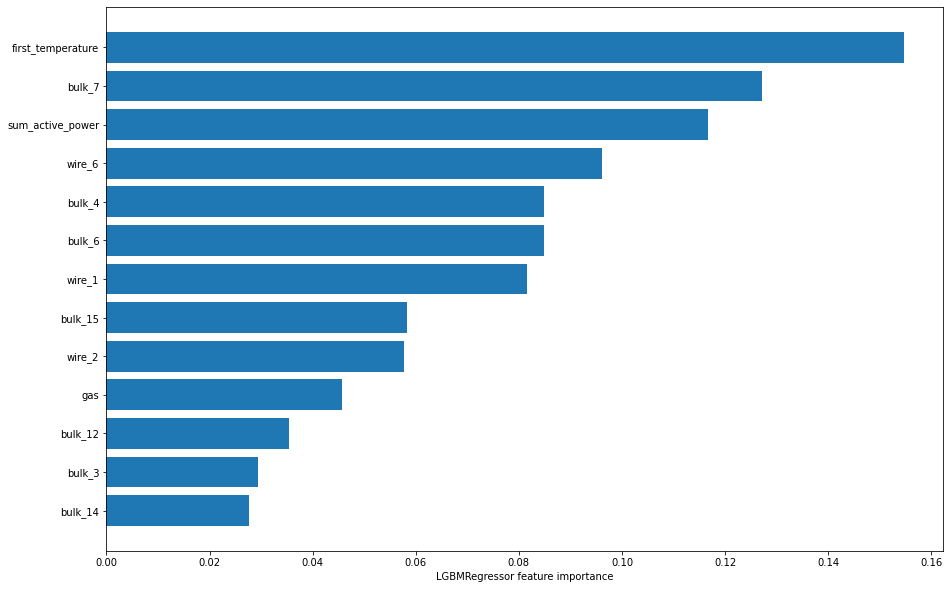

In [122]:
%%time
model = XGBRegressor()
model.set_params(**best_params_XGBR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_XGBR = mean_absolute_error(target_predict, target_test)
print('MAE XGBRegressor =', test_MAE_XGBR)

model.feature_importances_
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = model.feature_importances_.argsort()
plt.barh(features_test.columns.values[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("LGBMRegressor feature importance")

# Отчёт по решению:

В ходе решения задачи по пострению модели, которая предскажет температуру стали, для оптимизации производственных расходов металлургического комбината ООО "Так закаляем сталь", было произведено:

Исследование всех предоставленных данных об электродах,даныее о подаче сыпучих и проволочных материалов(объеме и времени),данные о продувке газом, и результат измерения температуры.

По результатам исследования данных провели их предобработку:

-избавились от ошибок в данных

-избавились от данных с пропуском замера температуры,для снижения вычислительной нагрузки 

-создали таблицу где просуммировали активную и реактивную мощность для каждой партии,

-создали таблицу где есть первый и последний замер температуры, 

-привели типы данных к целочисленным для ускорения работы и для правильной отработки алгоритмов, 

-выполнили оценку мультиколлинеарности,

-определили целевой признак - конечная температура,

-для работы модели на всем диапозоне параметров в данных не удаляли неявные выбросы,

-поделили данные на обучающую и тестовую выборки.

Конечным этапом решения выбрали и обучили модели:

LinearRegression, CatBoostRegressor, RandomForestRegressor,  LGBMRegressor, XGBRegressor.

С помощью GridSearchCV подобрали параметры модели.Лучшей по метрике MAE стала модель XGBRegressor, далее данная модель была проверена на тестовой выборке.

Результат модели XGBRegressor с параметрами {'learning_rate': 0.08, 'random_state': 12092022} на тестовой выборке - МАЕ = 6.6 

Этот результат показывает, что модель в среднем ошибается на 6-7 градусов температуры.Так же определены и отражены на графике, факторы важности по силе влияния на целевой признак. Самым важным фактором является первая температура, следом сыпучие материалы bulk_7, активная мощность и т.д.

Получившаяся модель пригодна для оптимизации производственных расходов.







